# WLS-ENO方法

已知未知量在网格单元内的平均值$\overline{f}_i$

- 根据一定的计算模版$\{I_j:j \in S_i\}$重构出网格单元$i$的近似分布$\tilde{f}_i(x)$

$$\overline{f}_i = \frac{1}{\vert \Omega_i \vert} \int_{\Omega_i} \tilde{f}_i(x) dx$$

其中$S_i$是网格单元$i$的邻居单元编号集合，也即是计算模版，$\vert \Omega_i \vert$是网格单元$i$的体积

- 在两个网格单元的交界面会得到两个值$q^-$和$q^+$，用来计算数值通量

- $p$次多项式形式为

$$\tilde{f}_i(x) = c_0 + c_1 x + c_2 x^2 + \dots + c_p x^p$$



In [1]:
from numpy import linspace, arange, float64, zeros, sin, pi, poly1d, sign
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from tqdm import trange

# 设置计算参数

In [2]:
nx = 64          # Grid number
np = 2           # Polynomial degree
ns = 5           # Stencil width
dt = 0.002       # Time step size (s)
nt = int(2 / dt) # Time step number

# 设置内部常数

通信边界宽度

In [3]:
nh = int((ns - 1) / 2)

网格编号边界（用于取实际计算网格）

In [4]:
ib = nh
ie = nx + nh # +1

计算模版中心的相对编号

In [5]:
s0 = nh

In [6]:
print('nx:', nx)
print('nh:', nh)
print('ib:', ib)
print('ie:', ie)
print('s0:', s0)

nx: 64
nh: 2
ib: 2
ie: 66
s0: 2


# 设置网格

这里先假设是等距网格

In [7]:
min_x = -1
max_x =  1

In [8]:
dx = (max_x - min_x) / nx

网格中心点坐标

In [9]:
x = arange(min_x - dx * nh, max_x + dx * nh, dx, dtype=float64)

网格边界坐标

In [10]:
xi = arange(x[0] - dx / 2, x[-1] + dx / 2, dx, dtype=float64)

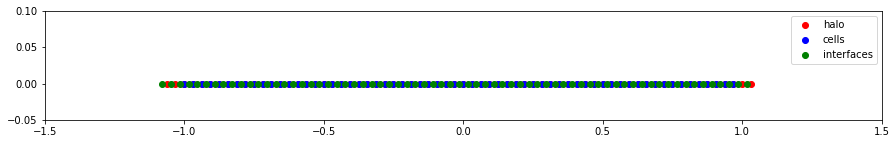

In [11]:
plt.figure(figsize=(15, 2))
plt.scatter(x, zeros(len(x)), c='r', label='halo')
plt.scatter(x[ib:ie], zeros(len(x[ib:ie])), c='b', label='cells')
plt.scatter(xi, zeros(len(xi)), c='g', label='interfaces')
plt.xlim(-1.5, 1.5)
plt.ylim(-0.05, 0.1)
plt.legend()

# 边界条件

In [12]:
def periodic_boundary(nh, f):
    f[:nh] = f[len(f)-2*nh:len(f)-nh]
    f[len(f)-nh:] = f[nh:2*nh]

(-0.05, 0.1)

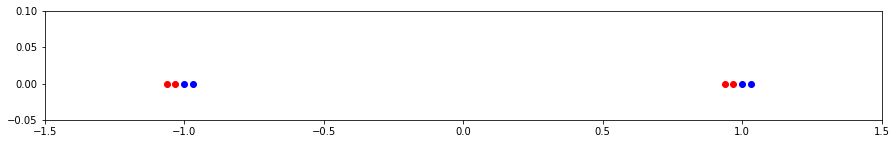

In [13]:
plt.figure(figsize=(15, 2))
plt.scatter(x[:nh], zeros(nh), c='r')
plt.scatter(x[len(x)-2*nh:len(x)-nh], zeros(nh), c='r')
plt.scatter(x[len(x)-nh:], zeros(nh), c='b')
plt.scatter(x[nh:2*nh], zeros(nh), c='b')
plt.xlim(-1.5, 1.5)
plt.ylim(-0.05, 0.1)

# 重构矩阵

重构矩阵的维度大小为$ns \times np+1$，以一维情况为例：
$$
\mathbf{R} = \left[ \begin{array}{cccc}
  \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}} - x_{i-s-\frac{1}{2}}\right) & \frac{1}{2} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^2 - x_{i-s-\frac{1}{2}}^2\right) & \dots & \frac{1}{p+1} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^{p+1} - x_{i-s-\frac{1}{2}}^{p+1}\right) \\
  \vdots & \vdots & \vdots & \vdots \\
  \frac{1}{\Delta{x}_{i}} \left(x_{i+\frac{1}{2}} - x_{i-\frac{1}{2}}\right) & \frac{1}{2} \frac{1}{\Delta{x}_{i}} \left(x_{i+\frac{1}{2}}^2 - x_{i-\frac{1}{2}}^2\right) & \dots & \frac{1}{p+1} \frac{1}{\Delta{x}_{i}} \left(x_{i+\frac{1}{2}}^{p+1} - x_{i-\frac{1}{2}}^{p+1}\right) \\
  \vdots & \vdots & \vdots & \vdots \\
  \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}} - x_{i-s-\frac{1}{2}}\right) & \frac{1}{2} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^2 - x_{i-s-\frac{1}{2}}^2\right) & \dots & \frac{1}{p+1} \frac{1}{\Delta{x}_{i-s}} \left(x_{i-s+\frac{1}{2}}^{p+1} - x_{i-s-\frac{1}{2}}^{p+1}\right)
\end{array} \right]
$$

其中$s$是网格单元$i$一侧的邻居网格数量。

$$\min \|\mathbf{W} \mathbf{R} \mathbf{c} - \mathbf{W} \overline{\mathbf{f}}\|_2$$

其中$\mathbf{W}$是对角权重矩阵，维度大小为$ns \times ns$，向量$\mathbf{c}$是待求重构系数或多项式系数。

In [14]:
R = zeros([ns, np+1])

for j in range(ns):
    # Relative coordinate (assume uniform grid interval)
    #
    #        o           o     ...    o    ...    o           o
    #  -(ns-1)/2*dx                   0                  (ns-1)/2*dx
    #
    xj = (j - s0) * dx
    xl = xj - dx / 2
    xr = xj + dx / 2
    for p in range(np+1):
        R[j,p] = (xr**(p + 1) - xl**(p + 1)) / (p + 1) / dx

# 初始条件

## 方波

In [15]:
def square_initial_condition(x):
    f = zeros(len(x))
    for i in range(len(x)):
        if -0.4 <= x[i] <= 0.4: f[i] = 1
    return f

## 正弦函数

In [16]:
def sine_initial_condition(x):
    f = sin(x / (max_x - min_x) * 2 * pi)
    return f

# 设置速度

In [17]:
u = zeros(len(xi))

## 常速度

In [18]:
u[:] = 1

# 一维平流空间算子

使用了Lax-Friedrichs通量分裂算法

$$F_{i+\frac{1}{2}} = \frac{1}{2} \left[\left(F(f_{i+\frac{1}{2}}^-) + F(f_{i+\frac{1}{2}}^+)\right) - \alpha \left(f_{i+\frac{1}{2}}^+ - f_{i+\frac{1}{2}}^-\right)\right]$$

其中$f_{i+\frac{1}{2}}^-$和$f_{i+\frac{1}{2}}^+$是边界$i+\frac{1}{2}$上左边值（来自网格单元$i$的重构）和右边值（来自网格单元$i+1$的重构）。

In [19]:
def space_operator(nx, x, dx, f):
    eps = 1.0e-5
    alpha = 10
    
    fl = zeros(len(x))
    fr = zeros(len(x))
    for i in range(ib, ie):
        fs = zeros(ns) # Stencil values
        si = zeros(ns) # Smoothness indicator
        for j in range(ns):
            fs[j] = f[i-nh+j]
            si[j] = (fs[j] - f[i])**2 + eps * (x[i-nh+j] - x[i])**2
        si[s0] = min(si[s0-1], si[s0+1])
        
        W = zeros([ns, ns])
        for j in range(ns):
            W[j,j] = 1 / si[j]
        W[s0,s0] *= alpha
        
        c = lstsq(W.dot(R), W.dot(fs), rcond=None)[0]
        fpoly = poly1d(list(reversed(c))) # in decreasing powers
        
        # Get the values of left and right edges of cell i.
        fl[i] = fpoly(-dx / 2)
        fr[i] = fpoly( dx / 2)

    # Apply boundary conditions.
    periodic_boundary(nh, fl)
    
    # Calculate numerical flux at right interfaces of cells.
    F = zeros(len(x))
    max_u = max(abs(u))
    for i in range(ib, ie):
        F[i] = 0.5 * ((u[i+1] * fl[i+1] + u[i] * fr[i]) - max_u * (fl[i+1] - fr[i]))
    periodic_boundary(nh, F)
    dFdx = zeros(len(x))
    for i in range(ib, ie):
        dFdx[i] = (F[i] - F[i-1]) / dx
    return dFdx

# 时间积分方案

In [20]:
def update(dt, dFdx, f):
    f_new = f
    f_new[ib:ie] = f[ib:ie] - dt * dFdx[ib:ie]
    periodic_boundary(nh, f_new)
    return f_new

## 四阶Runge-Kutta

In [21]:
def rk4(nx, x, dx, dt, f):
    dFdx1 = space_operator(nx, x, dx, f)
    f2 = update(0.5 * dt, dFdx1, f)

    dFdx2 = space_operator(nx, x, dx, f2)
    f3 = update(0.5 * dt, dFdx2, f)

    dFdx3 = space_operator(nx, x, dx, f3)
    f4 = update(dt, dFdx3, f)

    dFdx4 = space_operator(nx, x, dx, f4)

    dFdx = (dFdx1 + 2 * dFdx2 + 2 * dFdx3 + dFdx4) / 6

    return update(dt, dFdx, f)

## 三阶TVD Runge-Kutta

$$\begin{align}
f^{(1)} & = f^n + \Delta{t} L\left(f^n\right) \\
f^{(2)} & = \frac{3}{4} f^n + \frac{1}{4} f^{(1)} + \frac{1}{4} \Delta{t} L\left(f^{(1)}\right) \\
f^{n+1} & = \frac{1}{3} f^n + \frac{2}{3} f^{(2)} + \frac{2}{3} \Delta{t} L\left(f^{(2)}\right)
\end{align}$$

In [22]:
def rk3_tvd(nx, x, dx, dt, f):
    dFdx1 = space_operator(nx, x, dx, f)
    f1 = update(dt, dFdx1, f)
    
    dFdx2 = space_operator(nx, x, dx, f1)
    f2 = update(0.25 * dt, dFdx2, 0.75 * f + 0.25 * f1)
    
    dFdx3 = space_operator(nx, x, dx, f2)
    
    return update(2 / 3 * dt, dFdx3, f / 3 + f2 * 2 / 3)

# 运行模拟

In [ ]:
f = square_initial_condition(x)

plt.figure(figsize=(12, 8))
plt.plot(x[ib:ie], f[ib:ie], c='r', label='Initial condition')

m = zeros(nt)
for step in trange(nt):
    f = rk4(nx, x, dx, dt, f)
    m[step] = sum(f[ib:ie])

plt.plot(x[ib:ie], f[ib:ie], c='b', label='WLS-ENO at 2 seconds')
plt.ylim(-0.05, 1.2)
plt.annotate(f'''
Grid size: {nx}
Conservation relative error: {(m[nt-1] - m[0]) / m[0]:.2e}
Polynomial degree: {np}
Stencil size: {ns}
CFL: {max(u) * dt / dx}
''', (-1, 0.95))
plt.legend()

 34%|███▎      | 336/1000 [00:14<00:27, 23.88it/s]